In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
from datetime import datetime
from src import utils, plotting, scoring
from src.detector import CategoricalDriftDetector
from src.tracker import PerformanceTracker
from scipy.stats import ks_2samp

Dados

In [2]:
# Parâmetros
n_samples = 100000 
n_features = 20  
n_informative = 2   # Número de características informativas
n_redundant = 2    # Número de características redundantes
weights = [0.2, 0.8]  # Desbalanceamento
np.random.seed(42)
# Gerar os dados
X, y = make_classification(n_samples=n_samples, 
                           n_features=n_features, 
                           n_informative=n_informative, 
                           n_redundant=n_redundant, 
                           flip_y=0.05, 
                           random_state=42,
                           )

# Adicionar coluna com duas categorias
category_col = np.random.choice([0, 1], size=n_samples, p=weights)

# Adicionar coluna com diversas categorias (por exemplo, 5 categorias)
diverse_category_col = np.random.choice([0, 1, 2, 3, 4], size=n_samples)


In [3]:
# Criar DataFrame
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
df['discrete_0'] = category_col
df['discrete_1'] = diverse_category_col
df['target'] = y
df['datetime'] = utils.generate_random_dates_within_interval(datetime(2021, 1, 1), 4, n_samples)
df_train = df[df["datetime"] < '2024']
df_reference = df[(df["datetime"] >= '2024-01-01') & (df["datetime"] < '2024-07-01')].copy()
df_test = df[(df["datetime"] >= '2024-07-01')].copy()

In [4]:
X_train = df_train[df_train.columns[:-2]]
y_train = df_train["target"]

In [5]:
rf = RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1, class_weight="balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, oob_score=True,
                       random_state=42)

df_test

In [6]:
y_prob = rf.predict_proba(df_test[df_test.columns[:-2]])
y_pred = rf.predict(df_test[df_test.columns[:-2]])
y_prob = y_prob[np.arange(len(df_test)), y_pred]
df_test["y_prob"] = y_prob
df_test["prediction"] = y_pred

df_reference

In [7]:
y_prob = rf.predict_proba(df_reference[df_reference.columns[:-2]])
y_pred = rf.predict(df_reference[df_reference.columns[:-2]])
y_prob = y_prob[np.arange(len(y_prob)), y_pred]
df_reference["y_prob"] = y_prob
df_reference["prediction"] = y_pred

In [8]:
tracker = PerformanceTracker(df_reference, 'target', 'prediction', 'datetime', "W")

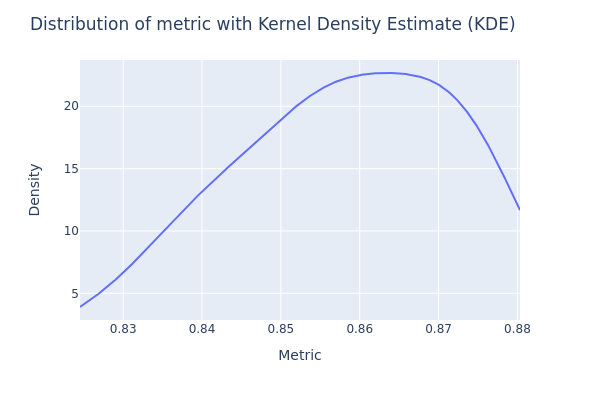

In [9]:
plotting.kde(tracker.reference_distribution, 'metric', fig_type="png")


In [10]:
tracker.statistics

{'ci_lower': 0.849188170501541,
 'ci_upper': 0.8653173623584285,
 'mean': 0.8576626839240847,
 'lower_threshold': 0.8138709085875395,
 'upper_threshold': 0.90145445926063}

# Reference

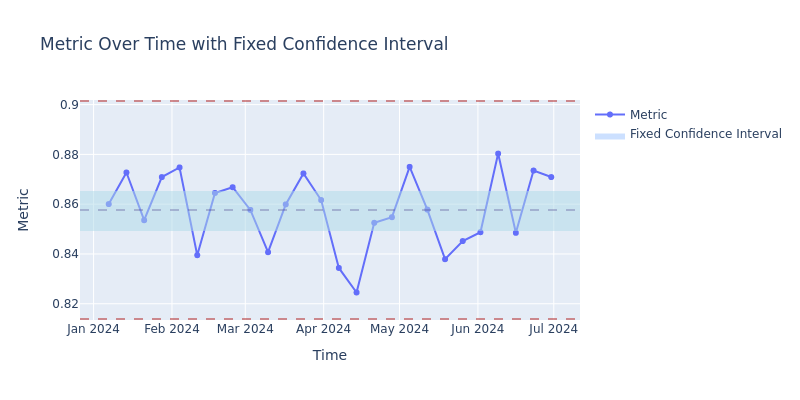

In [11]:
plotting.performance_by_time(tracker.statistics, tracker.reference_distribution, fig_type="png")

# Analysis

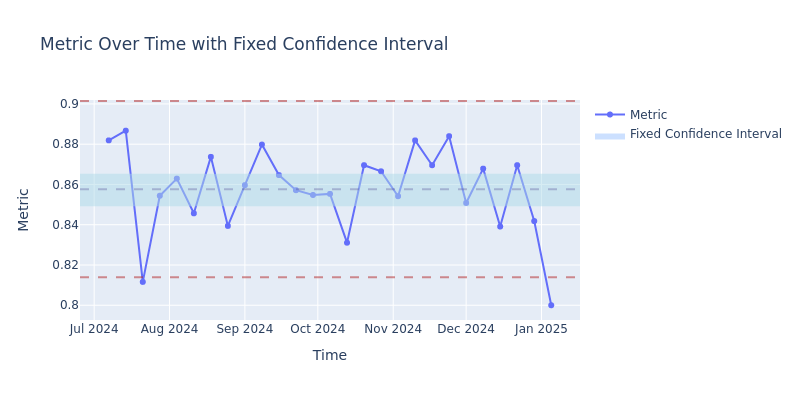

In [12]:
analysis_score = scoring.metric_by_time_period(df_test, 'target', 'prediction', 'datetime', 'W')
plotting.performance_by_time(tracker.statistics, analysis_score, fig_type="png")

# Discrete Data Drift

In [13]:
# Exemplo de uso:
detector = CategoricalDriftDetector(df_reference, 'discrete_1', "datetime", "W")

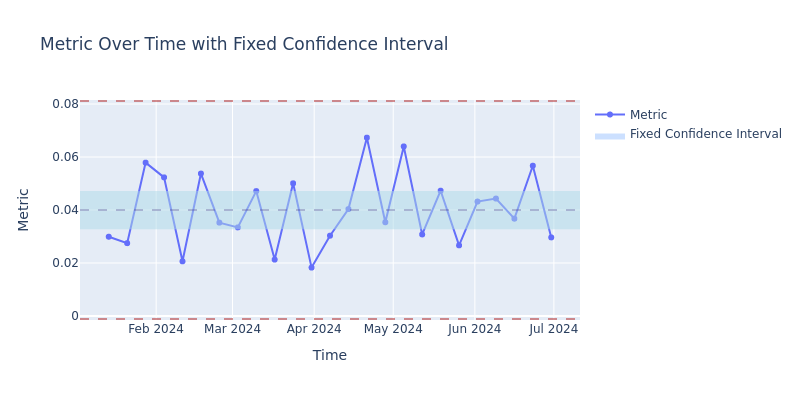

In [16]:
plotting.performance_by_time(detector.statistics, detector.reference_distance, fig_type="png")

In [26]:
test_distribution = detector._calculate_frequency(df_test, "discrete_1", "datetime", "W")
test_distance = detector._generate_distance(test_distribution, distance_func= "l_infinity")

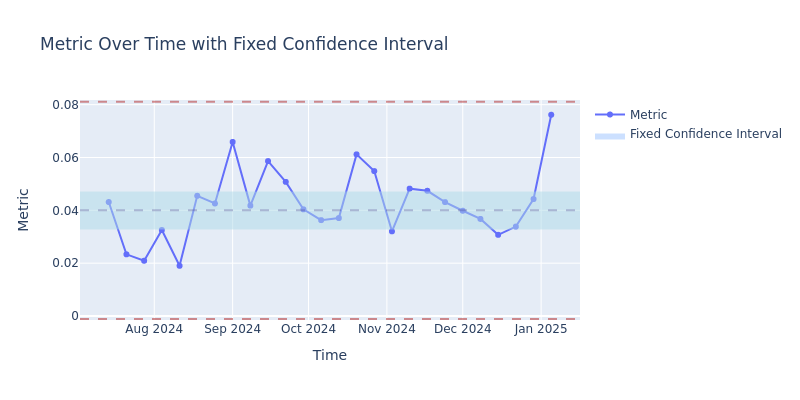

In [27]:
plotting.performance_by_time(detector.statistics, test_distance, fig_type="png")

# Continuous Data Drift

In [31]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp

def calculate_continuous_distribution(df, column_name, period, timestamp):
    """
    Calculates the continuous distribution grouped by a given period.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        column_name (str): Name of the column to aggregate.
        period (str): Period for grouping (e.g., '1D', '1H').
        timestamp (str): Name of the timestamp column.

    Returns:
        pd.Series: Series containing lists of values grouped by the specified period.
    """
    return (
        df[[timestamp, column_name]]
        .copy()
        .groupby(pd.Grouper(key=timestamp, freq=period))[column_name]
        .agg(list)
    )

def generate_ks_reference(p):
    """
    Calculates a metric based on the Kolmogorov-Smirnov test in a cummulative rolling window.

    Args:
        p (pd.Series): Series of lists representing distributions for each period.

    Returns:
        pd.DataFrame: DataFrame with the indices and calculated metric.
    """
    n = p.shape[0]
    p_values = np.zeros(n)
    past_values = np.array([], dtype=float)

    for i in range(1, n):
        past_values = np.concatenate([past_values, p[i - 1]])
        _, p_value = ks_2samp(past_values, p[i])
        p_values[i] = p_value

    return pd.DataFrame({"datetime": p.index[1:], "metric": p_values[1:]})


In [32]:
def kolmogorov_smirnov_test(a, b):
    _, p_value = ks_2samp(a, b)
    return p_value

In [33]:
def calculate_statistics(
        df, 
        statistic=np.mean,
        confidence_level=0.997,
        n_resamples=1000,
        random_state=42,):
        """
        Calculate statistics for the reference distances, including confidence intervals and thresholds.
        """
        ci_lower, ci_upper = scoring.bootstrapping_bca(
            df["metric"],
            confidence_level,
            statistic,
            n_resamples,
            random_state,
        )

        estimated_mean = np.mean(df["metric"])
        std_deviation = df["metric"].std()

        return {
            "ci_lower": ci_lower,
            "ci_upper": ci_upper,
            "mean": estimated_mean,
            "lower_threshold": 0.05,
            "upper_threshold": 1,
        }


In [34]:
reference_distribution = calculate_continuous_distribution(df_reference, "feature_0", "W", "datetime")
reference_ks = generate_ks_reference(reference_distribution)
statistics = calculate_statistics(reference_ks)

In [ ]:
plotting.performance_by_time(statistics, reference_ks)

In [36]:
reference = np.concatenate(reference_distribution)
test_distribution = calculate_continuous_distribution(df_test, "feature_0", "W", "datetime")
test_ks = test_distribution.apply(lambda x: ks_2samp(x, reference)[1]).rename("metric").reset_index()

In [ ]:
plotting.performance_by_time(statistics, test_ks)